## import

In [143]:
import cv2
import numpy as np
import PIL
from PIL import Image
import shutil,os,sys
import glob
from time import sleep
import time
import matplotlib.pyplot as plt
#import matplotlib.image as ImagePG

## 確認檔案

In [144]:
def CheckFile(path):
    filepath='Screen/transport/'+path.split("/")[-1] 
    if os.path.isfile(filepath):
        os.remove(filepath)

## 統一大小

In [218]:
#單改一張大小成448*448
def ChangeSize(filename):
        img=Image.open(filename)
        #改變影像
        img_new=img.resize((500,500),PIL.Image.ANTIALIAS)
        #注意斜線方向
        img_new.save('Screen/transport/'+filename.split("/")[-1] )

## 測試預處理效果

In [146]:
#去紅線、濾波器、銳利化 print 輸出圖結果
def Dilate(path):
    #灰階讀進
    image = cv2.imread(path, 0)
    #膨脹
    kernel = np.ones((3,3), np.uint8)
    #(圖檔案,捲機大小,迭代次數)
    dilate = cv2.dilate(image, kernel, iterations = 2)

    #降噪(中值濾波)，彌平紅線條
    image_mid_blur =cv2.medianBlur(dilate, 9) 
    #cv2.imwrite('Screen/transport/Test/1-'+path.split("/")[-1],image_mid_blur)
    #細線化(凸顯切割線)
    kernelN=np.ones((11,11),np.uint8)
    Negtive=cv2.erode(image_mid_blur,kernelN,iterations=1)
    
    #混和拉普拉斯(銳利化)
    '''一般銳利效果
    Kernel_Laplacian=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    temp=cv2.filter2D(Negtive,cv2.CV_32F,Kernel_Laplacian)
    Laplacian_Mix=np.uint8(np.clip(temp,0,255))
    '''
    Kernel_Laplacian2=np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    temp2=cv2.filter2D(Negtive,cv2.CV_32F,Kernel_Laplacian2)
    Laplacian_Mix2=np.uint8(np.clip(temp2,0,255))
    

    
    #雙邊濾波器
    #TwoSide_Process=cv2.bilateralFilter(image_mid_blur,3,50,50)
    
    #影像疊加(增加畫素，變清晰
    #先高斯濾波(影像,捲積核,標準差)，模糊鋸齒狀
    Gaussian=cv2.GaussianBlur(Negtive,(0,0),50)
    usm = cv2.addWeighted(Negtive, 1.5, Gaussian, -0.5, 0)
    
    Gaussian2=cv2.GaussianBlur(Negtive,(0,0),100)
    usm2 = cv2.addWeighted(Negtive, 1.5, Gaussian2, -0.5, 0)

    #取邊緣(下線數值,上線數值)
    #canny=cv2.Canny(Gaussian,10,80)
    
    #先膨脹再減侵蝕
    #侵蝕Kernel
    #kernelN=np.ones((3,3),np.uint8)
    #Negtive=cv2.erode(image_mid_blur,kernelN,iterations=1)
    #相減(前面膨脹-侵蝕)
    #result=cv2.absdiff(image_mid_blur,Negtive)
    
    #反二值化更清楚(輸出rst)
    #thr,reverse=cv2.threshold(result,4,10,cv2.THRESH_BINARY_INV)

    #二值化(輸出forward)
    #thr,forward=cv2.threshold(result,4,10,cv2.THRESH_BINARY)
    
    #截斷設定
    #thr,capture=cv2.threshold(result,50,120,cv2.THRESH_TRUNC)
    
    #超零定址(大於歸0，小於保持)
    #thr,supzeort=cv2.threshold(result,100,5,cv2.THRESH_TOZERO_INV)
    
    #定值設定(大於保持,小於歸0)
    #thr,zeort=cv2.threshold(result,4,100,cv2.THRESH_TOZERO)
    
    #方框濾波
    
    #連接圖片
    #Hstack_Image=np.hstack([Laplacian_Mix,Laplacian_Mix2])
    #Hstack_Image2=np.hstack([usm,Negtive])
    ''' 
    #原圖laplase
    gray_lap1 = cv2.Laplacian(image, cv2.CV_16S, ksize=3)
    dst1 = cv2.convertScaleAbs(gray_lap1) # 轉回uint8

    #去除紅線laplase
    gray_lap2 = cv2.Laplacian(dilate, cv2.CV_16S, ksize=3)
    dst2= cv2.convertScaleAbs(gray_lap2) # 轉回uint8
    
    #去除紅線+降噪laplase
    gray_lap3 = cv2.Laplacian(image_mid_blur, cv2.CV_16S, ksize=3)
    dst3 = cv2.convertScaleAbs(gray_lap3) # 轉回uint8
    cv2.imwrite('Screen/transport/Test/2-'+path.split("/")[-1],dst3)
    '''
    
    while True:
        #cv2.imshow('Input 1',Hstack_Image)
        #cv2.imshow('Input 2',Hstack_Image2)
        
        #cv2.imshow('sharp 1',Laplacian_Mix2)
        cv2.imshow('sharp 2',usm)
        cv2.imshow('sharp 3',usm2)
        
        #cv2.imshow('Laplacian 1', dst1)
        #cv2.imshow('Laplacian 2', dst2)
        #cv2.imshow('Laplacian 3', dst3)

        k = cv2.waitKey(0)
        if k == 27:
            cv2.destroyAllWindows()
            break



## 前處理(去紅線，凸顯特徵)

In [147]:
#圖片,要不要存檔
def ImageProcess(imgpath,switch):
    #灰階讀進
    img=cv2.imread('Screen/transport/'+imgpath.split("/")[-1],0)
    
    #start1 = time.time()
    
    #膨脹
    kernel = np.ones((3,3), np.uint8)
    dilate = cv2.dilate(img, kernel, iterations = 1)
    
    #降噪(中值濾波)，彌平紅線條
    image_mid_blur =cv2.medianBlur(dilate, 9) 
    #end1=time.time()
    #print("去紅線時間：%f 秒" % (end1 - start1))
    
    #start2 = time.time()
    #細線化(凸顯切割線)
    kernelN=np.ones((11,11),np.uint8)
    Negtive=cv2.erode(image_mid_blur,kernelN,iterations=1)

    #end2=time.time()
    #print("細線化時間：%f 秒" % (end2 - start2))
    
    #影像疊加(增加畫素，變清晰
    #先高斯濾波(影像,捲積核,標準差)，模糊鋸齒狀
    #start3 = time.time()
    Gaussian=cv2.GaussianBlur(Negtive,(0,0),50)
    #end3=time.time()
    #print("高斯時間：%f 秒" % (end3 - start3))
    
    #start4 = time.time()
    usm = cv2.addWeighted(Negtive, 1.5, Gaussian, -0.5, 0)
    #end4=time.time()
    #print("疊圖時間：%f 秒" % (end4 - start4))
    
    
    if switch == 1:
        #取檔案名
        #split處理檔名
        #注意斜線方向
        cv2.imwrite('Screen/transport/'+imgpath.split("/")[-1], usm)

## CheckSum-計算單通道的直方圖的相似值

In [190]:
# 計算單通道的直方圖的相似值 
def calculate(image1,image2): 
    #cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)
    hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
    hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 
    # 畫圖

    plt.plot(range(256),hist1,'r') 
    plt.plot(range(256),hist2,'b') 
    plt.show() 

    
    # 計算直方圖的重合度 
    degree = 0 
    for i in range(len(hist1)): 
        if hist1[i] != hist2[i]: 
            degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
        else: 
            degree = degree + 1 
    degree = degree/len(hist1)
    
    return degree 

## 設定門檻

In [149]:
def CompareThreshold():
    #用兩兩比較出的數值當作門檻
    #0.6881
    rate=calculate(cv2.imread('Screen/compare/c001.jpg'),cv2.imread('Screen/compare/c002.jpg'))
    return rate


## 掩模處理(Image Mask)

In [174]:
#--------用字典模仿Switch--------
#注意若沒輸入字典中的index會跳error

def left_up():#左上
        site=np.array([[[400,350],[0,350],[0,0],[400,0]]],dtype=np.int32)
        return site
def left_lower():#左下
        site=np.array([[[400,900],[0,9000],[0,500],[400,500]]],dtype=np.int32)
        return site
def right_up():#右上
        site=np.array([[[930,350],[530,350],[530,0],[950,0]]],dtype=np.int32)
        return site
def right_lower():#右下
        site=np.array([[[950,900],[500,900],[500,500],[950,500]]],dtype=np.int32)
        return site
def error():
    print("Keyin Error")
switch={0:left_up,1:left_lower,2:right_up,3:right_lower}
#--------用字典模仿switch --------
    
#擷取影像的其中一塊(暫放先不用)
#Input 已經被開啟的影像
def ImageMask(img,control):
    #顯示像素分布
    print(img.shape[:2])
    #建構三維模組
    #座標順序(x,y) 1:右下  左下 左上 右上 
    try:
        #使用模仿switch功能
        site=switch.get(control,"error")()
        '''用elif實作switch
        if(control=='left_up'):
            #左上
            site=np.array([[[400,350],[0,350],[0,0],[400,0]]],dtype=np.int32)
        elif(control=='left_lower'):
            #左下
            site=np.array([[[400,900],[0,900],[0,500],[400,500]]],dtype=np.int32)
        elif(control=='right_up'):
            #右上
            site=np.array([[[950,350],[530,350],[530,0],[950,0]]],dtype=np.int32)
        elif(control=='right_lower'):
            #右下
            site=np.array([[[950,900],[500,900],[500,500],[950,500]]],dtype=np.int32)
        '''
    except NameError as e:
        print("error",e)
    finally:
        im=np.zeros(img.shape[:2],dtype="uint8")
    cv2.fillPoly(im,site,255)
    
    mask=im
    while True:
        cv2.namedWindow('Mask',cv2.WINDOW_NORMAL)
        cv2.imshow('Mask',mask)
        masked=cv2.bitwise_and(img,img,mask=mask)
        cv2.namedWindow('Mask to Image',cv2.WINDOW_NORMAL)
        cv2.imshow('Mask to Image',masked)
        k=cv2.waitKey(0)
        if k==27:
            cv2.destroyAllWindows()
            break

In [176]:
'''
fileNO0='Screen/OG/OG008.jpg'
image=cv2.imread(fileNO0)
ImageMask(image,3)
'''

(852, 933)


## 合併比對

In [194]:
#(原圖,比較圖)
def CompareAlgo(file,file2):
    
    #確認重複檔名，避免比到舊的
    CheckFile(file)
    CheckFile(file2)
    sleep(1)
    #統一大小 function
    ChangeSize(file)
    ChangeSize(file2)
    
    #前處理影像 function 
    ImageProcess(file,1)
    ImageProcess(file2,1)
    
    #設定門檻 function
    threshold=0.73399866
    #相似度再比對門檻值0.6881+一個浮點數=0.73399866
    #threshold+=0.0452596
    
    #比對兩張相似度 function
    rate=calculate(cv2.imread('Screen/transport/'+file.split("/")[-1]),cv2.imread('Screen/transport/'+file2.split("/")[-1]))
    print(rate)

    #門檻值0.73399866
    if rate<threshold:
        return False
    if rate>=threshold:
        return True

    #測試時間
    '''
    start = time.time()
    end=time.time()
    print("執行時間：%f 秒" % (end - start))

    print(threshold)
    print(rate)
    '''

## 使用

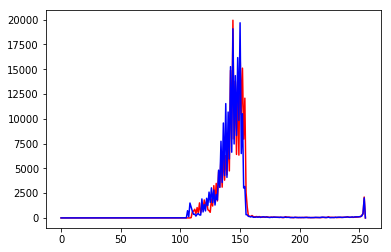

[0.8388401]
相同都沒切  True


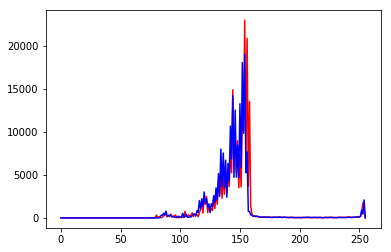

[0.79242116]
相同都有切  True


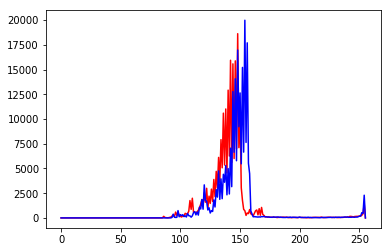

[0.73399866]
不同有切沒切_直條狀  True


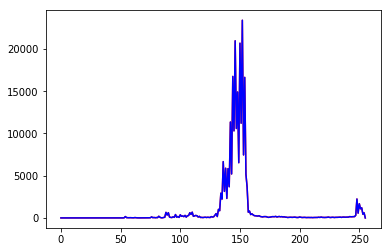

1.0
不同有切沒切_橫條狀  True


In [200]:

#相同(都沒切)
fileNO0='Screen/transport/OG/OG001.jpg'
fileNO1='Screen/transport/OG/OG002.jpg'
#相同(都有切)
file1='Screen/transport/OG/OG003.jpg'
file2='Screen/transport/OG/OG004.jpg'
#不同(有切沒切_直條狀)
file3='Screen/transport/OG/OG005.jpg'
file4='Screen/transport/OG/OG006.jpg'
#不同(有切沒切_橫條狀)
file5='Screen/transport/OG/OGT001.jpg'
file6='Screen/transport/OG/OGT002.jpg'
print("相同都沒切 ",CompareAlgo(fileNO0,fileNO1))
print("相同都有切 ",CompareAlgo(file1,file2))
print("不同有切沒切_直條狀 ",CompareAlgo(file3,file4))
print("不同有切沒切_橫條狀 ",CompareAlgo(file5,file6))

